# 학습 결과

user1의 scene 1~3만 사용해서 학습

scene보다 user가 많기 때문에 데이터의 양이 확연히 줄어듬에도 불구하고 성능이 괜찮음.  
적은 데이터 특화됐기 때문인지는 모르겠다.

나머지 scene에 대해서도 잘 학습을 하면서 user에 대해서도 특화된다면 성능을 상당히 끌어올릴 수 있을 것으로 기대됨.  
--> curriculum learning

In [1]:
from multiprocessing import cpu_count
from pathlib import Path
from typing import List, Union, AnyStr
from math import pi
import pickle

import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn import model_selection
from tqdm import tqdm
import torch_optimizer
from torch.utils.data import Dataset
import pandas as pd
import random

import torch_burn as tb
import utils

In [2]:
EXPERIMENT_NAME = '1122-Scene3-CLSTM2-dropout-win48'
CHECKPOINT_DIR = Path('checkpoint', EXPERIMENT_NAME)
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

DATA_DIR = Path('data/1116')
TRAIN_FILES = sorted(list(DATA_DIR.glob('*scene3_0.csv')))
TEST_FILES = sorted(list(DATA_DIR.glob('*scene3_1.csv')))

# 데이터셋 생성

scene1에 대해서 모든 user의 데이터를 하나로 합친다.

In [3]:
WINDOW_SIZE = 48

In [4]:
class CSVSequentialDataset(Dataset):
    def __init__(self, csvfile,
                 window_size=300, randomized_window_size=False,
                 stride=30, randomized_stride=False):
        super(CSVSequentialDataset, self).__init__()

        self.xcols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll',
                      'acceleration_x', 'acceleration_y', 'acceleration_z']
        self.ycols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll']

        self.csv = pd.read_csv(csvfile)
        self.window_size = window_size

        self.indexes = []
        i = 0
        while i <= len(self.csv) - window_size * 2:
            if randomized_window_size:
                self.indexes.append((i, i + random.randint(window_size // 2, window_size)))
            else:
                self.indexes.append((i, i + window_size))

            if randomized_stride:
                i += random.randint(1, stride)
            else:
                i += stride

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, idx):
        s, t = self.indexes[idx]
        x = self.csv.iloc[s:t][self.xcols].to_numpy()
        y = self.csv.iloc[t + 6][self.ycols].to_numpy()

        x = torch.tensor(x, dtype=torch.float32) # 300, 6
        y = torch.tensor(y, dtype=torch.float32) # 3
        
        #x[:, :3] *= pi / 180
        x[:, 3:] /= 10

        return x, y

In [5]:
ds_train = [CSVSequentialDataset(f,  
                                 window_size=WINDOW_SIZE, randomized_window_size=False,
                                 stride=5, randomized_stride=True) for f in TRAIN_FILES]
ds_train = tb.data.ChainDataset(*ds_train)
ds_test = [CSVSequentialDataset(f,  
                                window_size=WINDOW_SIZE, randomized_window_size=False,
                                stride=5, randomized_stride=True) for f in TEST_FILES]
ds_test = tb.data.ChainDataset(*ds_test)

In [6]:
len(ds_train), len(ds_test)

(18735, 18088)

In [7]:
ds_train[0][0].shape, ds_train[0][1].shape

(torch.Size([48, 6]), torch.Size([3]))

In [8]:
x, y = ds_train[0]

In [9]:
x.shape

torch.Size([48, 6])

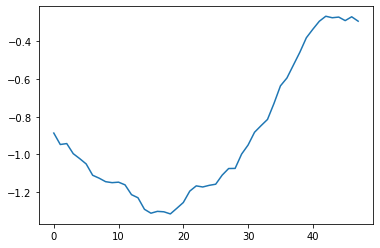

In [10]:
plt.plot(x[:, 2])

# 모델 생성

In [11]:
class CLSTM(nn.Module):
    def __init__(self, input_size=6, hidden_size=24, num_layers=8, dropout=0.0, bidirectional=False):
        super(CLSTM, self).__init__()

        self.conv_in = nn.Sequential(
            nn.Conv1d(input_size, 12, 5, padding=2),
            nn.BatchNorm1d(12),
            nn.LeakyReLU(),
            nn.Conv1d(12, 24, 5, padding=2),
            nn.BatchNorm1d(24),
        )

        self.rnn = nn.LSTM(input_size=24,
                           hidden_size=hidden_size,
                           num_layers=num_layers,
                           batch_first=True,
                           dropout=dropout,
                           bidirectional=bidirectional)

        out_channels = 2 * hidden_size if bidirectional else hidden_size
        self.fc = nn.Sequential(
            nn.Linear(out_channels, out_channels // 2),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(out_channels // 2, 3)
        )

    def forward(self, x):
        x = x.transpose(1, 2)  # B, 48, 6 --> B, 6, 48
        x = self.conv_in(x)  # B, 64, 48
        x = x.transpose(1, 2)  # B, 48, 64

        outs, (hiddens, cells) = self.rnn(x)
        x = outs[:, -1, ...]
        x = self.fc(x)

        return x

In [12]:
model = CLSTM(input_size=6, hidden_size=64, num_layers=8, dropout=0.2, bidirectional=True).cuda()

In [13]:
criterion = nn.MSELoss().cuda()
optimizer = torch_optimizer.RAdam(model.parameters())

In [14]:
metrics = [tb.metrics.ModuleMetric(criterion, 'loss'),
           utils.HPMetric('hp_metric'),
           utils.HPSignalHistory(CHECKPOINT_DIR / 'sample' / '{epoch:04d}.npy', 'hp_signal', verbose=False)]

In [15]:
callbacks = [tb.callbacks.EarlyStopping(metrics[0]),
             tb.callbacks.LRDecaying(optimizer, metrics[0])]

In [16]:
trainer = tb.Trainer(model, optimizer, metrics, callbacks, ncols=100)

In [18]:
trainer.fit(ds_train, ds_test, start_epoch=101, num_epochs=200, batch_size=256, shuffle=True, pin_memory=True)

[0102/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.993626
 - Pitch        :   0.921879
 - Roll         :   2.159051
 - RMS          :   1.471808
 - 99% Tile     :   7.091050


[0103/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   1.013863
 - Pitch        :   0.898855
 - Roll         :   2.163293
 - RMS          :   1.473736
 - 99% Tile     :   7.178770


[0104/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.979474
 - Pitch        :   0.892288
 - Roll         :   2.148239
 - RMS          :   1.457221
 - 99% Tile     :   7.096126


[0105/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.909477
 - Pitch        :   0.921561
 - Roll         :   2.152188
 - RMS          :   1.450096
 - 99% Tile     :   7.156167


[0106/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.905612
 - Pitch        :   0.879998
 - Roll         :   2.155230
 - RMS          :   1.442168
 - 99% Tile     :   7.114347


[0107/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.968807
 - Pitch        :   1.000450
 - Roll         :   2.119742
 - RMS          :   1.464331
 - 99% Tile     :   7.063752


[0108/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.120696
 - Pitch        :   0.890308
 - Roll         :   2.119943
 - RMS          :   1.476795
 - 99% Tile     :   7.065934


[0109/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.961347
 - Pitch        :   0.914935
 - Roll         :   2.122138
 - RMS          :   1.445079
 - 99% Tile     :   7.055684


[0110/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.990283
 - Pitch        :   0.932153
 - Roll         :   2.102490
 - RMS          :   1.445687
 - 99% Tile     :   7.017225


[0111/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.152565
 - Pitch        :   0.927474
 - Roll         :   2.100702
 - RMS          :   1.483415
 - 99% Tile     :   7.174766


[0112/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.013211
 - Pitch        :   0.940526
 - Roll         :   2.071618
 - RMS          :   1.437914
 - 99% Tile     :   6.958413


[0113/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.092997
 - Pitch        :   0.916396
 - Roll         :   2.039506
 - RMS          :   1.436896
 - 99% Tile     :   6.970509


[0114/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.927674
 - Pitch        :   1.065632
 - Roll         :   2.023722
 - RMS          :   1.424968
 - 99% Tile     :   6.910247


[0115/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.003957
 - Pitch        :   0.977503
 - Roll         :   1.992899
 - RMS          :   1.406543
 - 99% Tile     :   6.831850


[0116/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.939048
 - Pitch        :   0.919069
 - Roll         :   1.963811
 - RMS          :   1.364191
 - 99% Tile     :   6.924851


[0117/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.927057
 - Pitch        :   0.972304
 - Roll         :   1.912735
 - RMS          :   1.349490
 - 99% Tile     :   6.824473


[0118/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.978737
 - Pitch        :   0.974994
 - Roll         :   1.832958
 - RMS          :   1.325176
 - 99% Tile     :   6.755923


[0119/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.959180
 - Pitch        :   1.000075
 - Roll         :   1.762448
 - RMS          :   1.294398
 - 99% Tile     :   6.722774


[0120/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.967621
 - Pitch        :   1.023525
 - Roll         :   1.664575
 - RMS          :   1.258929
 - 99% Tile     :   6.642389


[0121/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.040341
 - Pitch        :   1.003490
 - Roll         :   1.605704
 - RMS          :   1.247342
 - 99% Tile     :   6.647829


[0122/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.995029
 - Pitch        :   0.972454
 - Roll         :   1.503014
 - RMS          :   1.182483
 - 99% Tile     :   6.599548


[0123/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.015082
 - Pitch        :   0.983213
 - Roll         :   1.470815
 - RMS          :   1.177624
 - 99% Tile     :   6.576721


[0124/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.069766
 - Pitch        :   1.032887
 - Roll         :   1.402727
 - RMS          :   1.180240
 - 99% Tile     :   6.553697


[0125/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.022488
 - Pitch        :   0.993745
 - Roll         :   1.345032
 - RMS          :   1.131683
 - 99% Tile     :   6.495603


[0126/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.117393
 - Pitch        :   0.967667
 - Roll         :   1.284632
 - RMS          :   1.130667
 - 99% Tile     :   6.535341


[0127/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.022803
 - Pitch        :   1.100857
 - Roll         :   1.267148
 - RMS          :   1.134853
 - 99% Tile     :   6.378379


[0128/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.042876
 - Pitch        :   0.989914
 - Roll         :   1.209996
 - RMS          :   1.084990
 - 99% Tile     :   6.419836


[0129/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.035388
 - Pitch        :   0.951614
 - Roll         :   1.223385
 - RMS          :   1.076146
 - 99% Tile     :   6.378999


[0130/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.053329
 - Pitch        :   0.896303
 - Roll         :   1.194159
 - RMS          :   1.054969
 - 99% Tile     :   6.557934


[0131/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.100755
 - Pitch        :   1.016484
 - Roll         :   1.170725
 - RMS          :   1.097800
 - 99% Tile     :   6.355498


[0132/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.037912
 - Pitch        :   0.966293
 - Roll         :   1.174570
 - RMS          :   1.063108
 - 99% Tile     :   6.318561


[0133/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.027156
 - Pitch        :   0.880529
 - Roll         :   1.188718
 - RMS          :   1.039780
 - 99% Tile     :   6.376744


[0134/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.982152
 - Pitch        :   0.934809
 - Roll         :   1.150593
 - RMS          :   1.026703
 - 99% Tile     :   6.300364


[0135/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.043966
 - Pitch        :   0.930096
 - Roll         :   1.120226
 - RMS          :   1.034384
 - 99% Tile     :   6.271277


[0136/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.989279
 - Pitch        :   0.961767
 - Roll         :   1.097334
 - RMS          :   1.017810
 - 99% Tile     :   6.212342


[0137/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.945048
 - Pitch        :   0.972321
 - Roll         :   1.105140
 - RMS          :   1.009927
 - 99% Tile     :   6.264043


[0138/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.162519
 - Pitch        :   0.878352
 - Roll         :   1.084821
 - RMS          :   1.048776
 - 99% Tile     :   6.324886


[0139/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.033731
 - Pitch        :   0.919935
 - Roll         :   1.061070
 - RMS          :   1.006769
 - 99% Tile     :   6.322229


[0140/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.078804
 - Pitch        :   0.939426
 - Roll         :   1.080137
 - RMS          :   1.034897
 - 99% Tile     :   6.146368


[0141/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.906771
 - Pitch        :   0.930217
 - Roll         :   1.058341
 - RMS          :   0.967406
 - 99% Tile     :   6.221069


[0142/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.019728
 - Pitch        :   0.896542
 - Roll         :   1.049495
 - RMS          :   0.990803
 - 99% Tile     :   6.161826


[0143/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.041347
 - Pitch        :   0.922116
 - Roll         :   1.073915
 - RMS          :   1.014560
 - 99% Tile     :   6.198643


[0144/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.950258
 - Pitch        :   0.885580
 - Roll         :   1.021197
 - RMS          :   0.953954
 - 99% Tile     :   6.205440


[0145/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.020640
 - Pitch        :   0.833343
 - Roll         :   1.027567
 - RMS          :   0.964721
 - 99% Tile     :   6.133887


[0146/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.031424
 - Pitch        :   0.846747
 - Roll         :   1.031367
 - RMS          :   0.973744
 - 99% Tile     :   6.097283


[0147/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.961949
 - Pitch        :   0.960194
 - Roll         :   1.026971
 - RMS          :   0.983529
 - 99% Tile     :   6.145043


[0148/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.971098
 - Pitch        :   0.908714
 - Roll         :   1.004733
 - RMS          :   0.962338
 - 99% Tile     :   6.164908


[0149/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.942268
 - Pitch        :   0.901401
 - Roll         :   0.980964
 - RMS          :   0.942105
 - 99% Tile     :   6.180297


[0150/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.160681
 - Pitch        :   0.935079
 - Roll         :   0.964435
 - RMS          :   1.024970
 - 99% Tile     :   6.095565


[0151/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.991947
 - Pitch        :   0.830587
 - Roll         :   0.998618
 - RMS          :   0.943587
 - 99% Tile     :   6.068860


[0152/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.006708
 - Pitch        :   0.870678
 - Roll         :   0.983177
 - RMS          :   0.955367
 - 99% Tile     :   6.068002


[0153/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.290387
 - Pitch        :   1.383702
 - Roll         :   0.966200
 - RMS          :   1.226549
 - 99% Tile     :   6.408099


[0154/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.015117
 - Pitch        :   0.914053
 - Roll         :   0.964682
 - RMS          :   0.965499
 - 99% Tile     :   6.033807


[0155/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.036530
 - Pitch        :   0.819057
 - Roll         :   0.956323
 - RMS          :   0.941595
 - 99% Tile     :   6.019249


[0156/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.991002
 - Pitch        :   0.797526
 - Roll         :   1.007209
 - RMS          :   0.936768
 - 99% Tile     :   6.082424


[0157/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.906256
 - Pitch        :   0.822198
 - Roll         :   0.960408
 - RMS          :   0.898089
 - 99% Tile     :   6.020621


[0158/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.937969
 - Pitch        :   0.930350
 - Roll         :   0.947412
 - RMS          :   0.938603
 - 99% Tile     :   5.966216


[0159/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.008075
 - Pitch        :   0.848842
 - Roll         :   0.954204
 - RMS          :   0.939371
 - 99% Tile     :   5.959264


[0160/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.170260
 - Pitch        :   0.893971
 - Roll         :   0.929329
 - RMS          :   1.005376
 - 99% Tile     :   5.945241


[0161/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   1.039025
 - Pitch        :   0.822203
 - Roll         :   0.949650
 - RMS          :   0.941174
 - 99% Tile     :   5.900083


[0162/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.878469
 - Pitch        :   0.877410
 - Roll         :   0.950828
 - RMS          :   0.902890
 - 99% Tile     :   5.970704


[0163/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.916169
 - Pitch        :   0.834883
 - Roll         :   0.965055
 - RMS          :   0.906960
 - 99% Tile     :   5.971030


[0164/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.962778
 - Pitch        :   0.805703
 - Roll         :   0.986500
 - RMS          :   0.921824
 - 99% Tile     :   5.904805


[0165/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.984782
 - Pitch        :   0.822528
 - Roll         :   0.925313
 - RMS          :   0.913337
 - 99% Tile     :   5.851600


[0166/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.956569
 - Pitch        :   0.857269
 - Roll         :   0.928785
 - RMS          :   0.915164
 - 99% Tile     :   5.874638


[0167/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.098931
 - Pitch        :   0.906880
 - Roll         :   0.907673
 - RMS          :   0.975355
 - 99% Tile     :   5.895070


[0168/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.011950
 - Pitch        :   0.822152
 - Roll         :   0.913926
 - RMS          :   0.919282
 - 99% Tile     :   5.890487


[0169/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.131684
 - Pitch        :   0.757544
 - Roll         :   1.006263
 - RMS          :   0.977607
 - 99% Tile     :   5.927940


[0170/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.895633
 - Pitch        :   0.794921
 - Roll         :   0.943887
 - RMS          :   0.880337
 - 99% Tile     :   5.866984


[0171/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.895238
 - Pitch        :   0.816629
 - Roll         :   0.905690
 - RMS          :   0.873424
 - 99% Tile     :   5.888929


[0172/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.911869
 - Pitch        :   0.830907
 - Roll         :   0.920877
 - RMS          :   0.888806
 - 99% Tile     :   5.810718


[0173/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.883359
 - Pitch        :   0.880484
 - Roll         :   0.903244
 - RMS          :   0.889086
 - 99% Tile     :   5.818317


[0174/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.918779
 - Pitch        :   0.870514
 - Roll         :   0.927308
 - RMS          :   0.905879
 - 99% Tile     :   5.834852


[0175/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.932422
 - Pitch        :   0.807644
 - Roll         :   0.931987
 - RMS          :   0.892618
 - 99% Tile     :   5.854888


[0176/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.843962
 - Pitch        :   0.836519
 - Roll         :   0.938707
 - RMS          :   0.874301
 - 99% Tile     :   5.830674


[0177/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.142479
 - Pitch        :   0.862942
 - Roll         :   0.923750
 - RMS          :   0.983741
 - 99% Tile     :   5.810156


[0178/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.993460
 - Pitch        :   0.855108
 - Roll         :   0.883162
 - RMS          :   0.912533
 - 99% Tile     :   5.765984


[0179/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.103896
 - Pitch        :   0.830434
 - Roll         :   0.879143
 - RMS          :   0.945357
 - 99% Tile     :   5.780567


[0180/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   1.040660
 - Pitch        :   0.890955
 - Roll         :   0.856611
 - RMS          :   0.932837
 - 99% Tile     :   5.823906


[0181/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.889607
 - Pitch        :   0.839142
 - Roll         :   0.903222
 - RMS          :   0.877756
 - 99% Tile     :   5.778767


[0182/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.071529
 - Pitch        :   0.892689
 - Roll         :   0.909977
 - RMS          :   0.961444
 - 99% Tile     :   5.778118


[0183/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.875939
 - Pitch        :   0.790754
 - Roll         :   0.881047
 - RMS          :   0.850256
 - 99% Tile     :   5.749598


[0184/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.927992
 - Pitch        :   0.819565
 - Roll         :   0.901444
 - RMS          :   0.884206
 - 99% Tile     :   5.771357


[0185/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.977237
 - Pitch        :   0.778219
 - Roll         :   0.864602
 - RMS          :   0.877145
 - 99% Tile     :   5.703367


[0186/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.973842
 - Pitch        :   0.841619
 - Roll         :   0.882470
 - RMS          :   0.901008
 - 99% Tile     :   5.705519


[0187/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   1.054795
 - Pitch        :   0.823311
 - Roll         :   0.897010
 - RMS          :   0.930064
 - 99% Tile     :   5.692689


[0188/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

Decaying lr from 0.000125 to 6.25e-05 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   1.004965
 - Pitch        :   0.789664
 - Roll         :   0.896658
 - RMS          :   0.901392
 - 99% Tile     :   5.809473


[0189/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.929337
 - Pitch        :   0.780689
 - Roll         :   0.868319
 - RMS          :   0.861611
 - 99% Tile     :   5.709681


[0190/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.882457
 - Pitch        :   0.811047
 - Roll         :   0.915735
 - RMS          :   0.870842
 - 99% Tile     :   5.720726


[0191/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.901873
 - Pitch        :   0.748108
 - Roll         :   0.887787
 - RMS          :   0.848765
 - 99% Tile     :   5.693940


[0192/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.905018
 - Pitch        :   0.742757
 - Roll         :   0.870031
 - RMS          :   0.842160
 - 99% Tile     :   5.696025


[0193/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.862361
 - Pitch        :   0.766408
 - Roll         :   0.834094
 - RMS          :   0.821941
 - 99% Tile     :   5.671545


[0194/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.905303
 - Pitch        :   0.866038
 - Roll         :   0.832892
 - RMS          :   0.868582
 - 99% Tile     :   5.652086


[0195/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.895602
 - Pitch        :   0.793197
 - Roll         :   0.861991
 - RMS          :   0.851331
 - 99% Tile     :   5.623825


[0196/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.887268
 - Pitch        :   0.844850
 - Roll         :   0.827322
 - RMS          :   0.853518
 - 99% Tile     :   5.627386


[0197/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   0.905755
 - Pitch        :   0.786625
 - Roll         :   0.829655
 - RMS          :   0.842120
 - 99% Tile     :   5.638055


[0198/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.843395
 - Pitch        :   0.780438
 - Roll         :   0.814873
 - RMS          :   0.813310
 - 99% Tile     :   5.627076


[0199/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.018119
 - Pitch        :   0.814228
 - Roll         :   0.873706
 - RMS          :   0.906071
 - 99% Tile     :   5.644281


[0200/0200] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.831805
 - Pitch        :   0.847002
 - Roll         :   0.862261
 - RMS          :   0.847114
 - 99% Tile     :   5.615723


[0200/0200] Validation: 100%|██████████████████████| 71/71 [00:02<00:00, 32.86it/s, val_loss 2.4153]


val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.894345
 - Pitch        :   0.796033
 - Roll         :   0.836978
 - RMS          :   0.843416
 - 99% Tile     :   5.604769
